In [ ]:
import pandas as pd

# Load customer churn dataset
customers = pd.read_csv("/content/churn.csv")

# Preview data
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
customers.shape
customers.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
# Drop columns that have no business value
customers_clean = customers.drop(
    columns=["RowNumber", "CustomerId", "Surname"]
)

customers_clean.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
customers_clean.isnull().sum()


,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


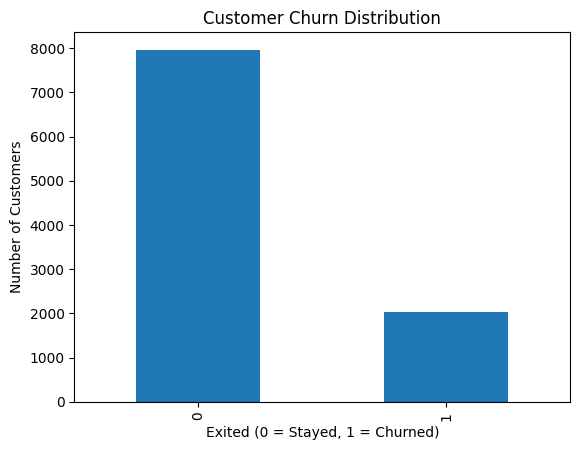

In [ ]:
import matplotlib.pyplot as plt

customers_clean['Exited'].value_counts().plot(kind='bar')
plt.title("Customer Churn Distribution")
plt.xlabel("Exited (0 = Stayed, 1 = Churned)")
plt.ylabel("Number of Customers")
plt.show()


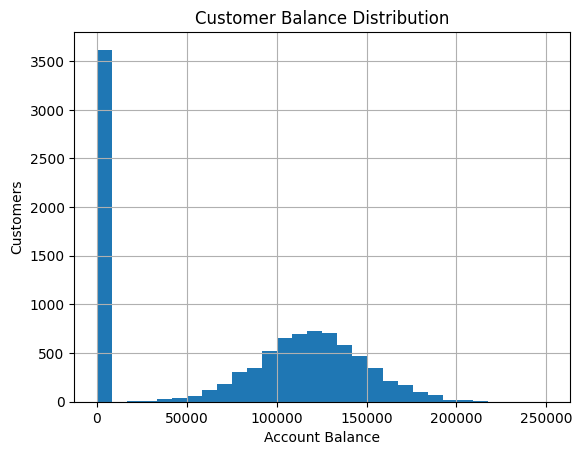

In [ ]:
customers_clean['Balance'].hist(bins=30)
plt.title("Customer Balance Distribution")
plt.xlabel("Account Balance")
plt.ylabel("Customers")
plt.show()


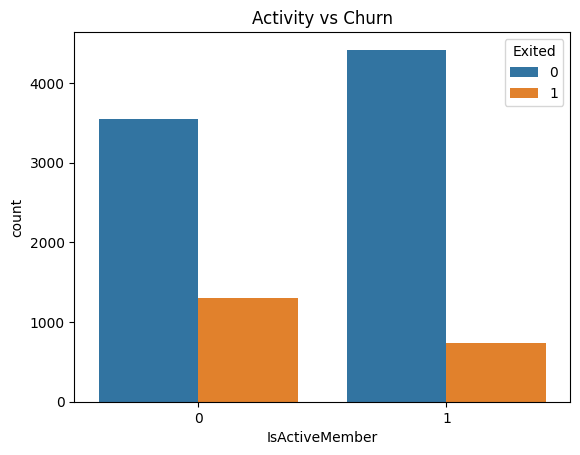

In [ ]:
import seaborn as sns

sns.countplot(x='IsActiveMember', hue='Exited', data=customers_clean)
plt.title("Activity vs Churn")
plt.show()


In [ ]:
# Normalise key value drivers
customers_clean['Balance_norm'] = customers_clean['Balance'] / customers_clean['Balance'].max()
customers_clean['Salary_norm'] = customers_clean['EstimatedSalary'] / customers_clean['EstimatedSalary'].max()
customers_clean['Products_norm'] = customers_clean['NumOfProducts'] / customers_clean['NumOfProducts'].max()

# Customer Value Score
customers_clean['Customer_Value_Score'] = (
    0.5 * customers_clean['Balance_norm'] +
    0.3 * customers_clean['Salary_norm'] +
    0.2 * customers_clean['Products_norm']
)


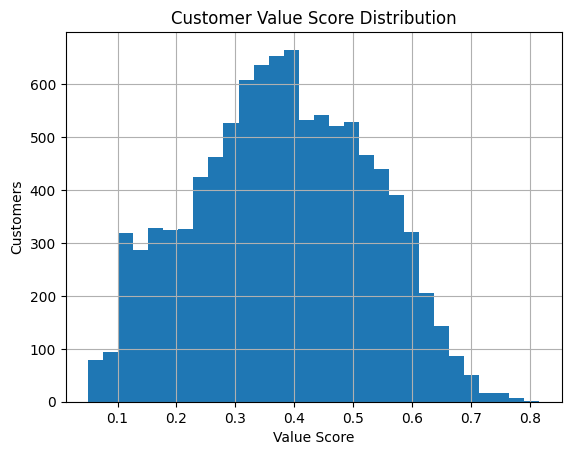

In [ ]:
customers_clean['Customer_Value_Score'].hist(bins=30)
plt.title("Customer Value Score Distribution")
plt.xlabel("Value Score")
plt.ylabel("Customers")
plt.show()


In [ ]:
customers_clean['Engagement_Score'] = (
    customers_clean['IsActiveMember'] * 0.6 +
    (customers_clean['Tenure'] / customers_clean['Tenure'].max()) * 0.4
)


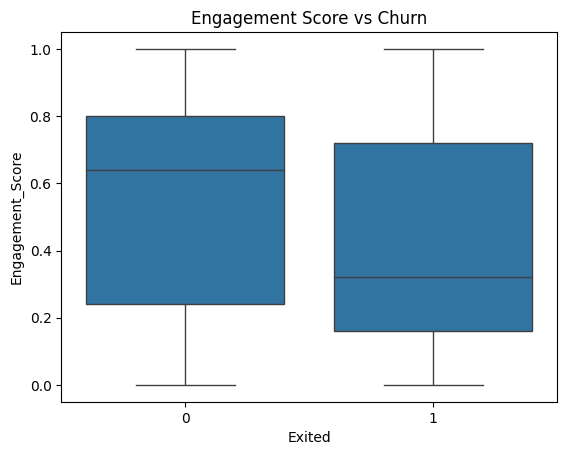

In [ ]:
sns.boxplot(x='Exited', y='Engagement_Score', data=customers_clean)
plt.title("Engagement Score vs Churn")
plt.show()


In [ ]:
customers_clean['Price_Sensitivity'] = (
    (1 - customers_clean['IsActiveMember']) * 0.4 +
    (customers_clean['NumOfProducts'] == 1).astype(int) * 0.3 +
    (customers_clean['Balance_norm'] < 0.3).astype(int) * 0.3
)


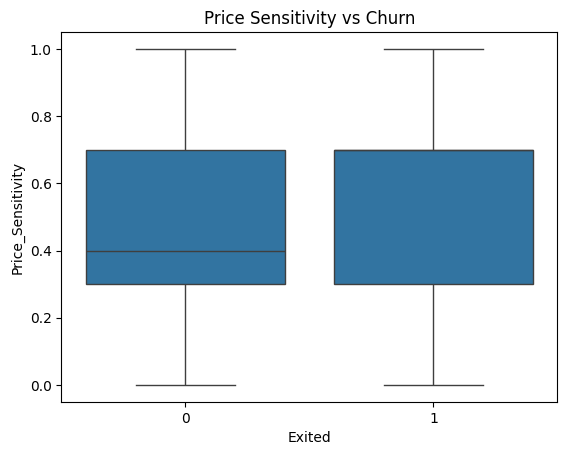

In [ ]:
sns.boxplot(x='Exited', y='Price_Sensitivity', data=customers_clean)
plt.title("Price Sensitivity vs Churn")
plt.show()


In [ ]:
segment_features = customers_clean[
    ['Customer_Value_Score', 'Engagement_Score', 'Price_Sensitivity']
]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
segment_scaled = scaler.fit_transform(segment_features)


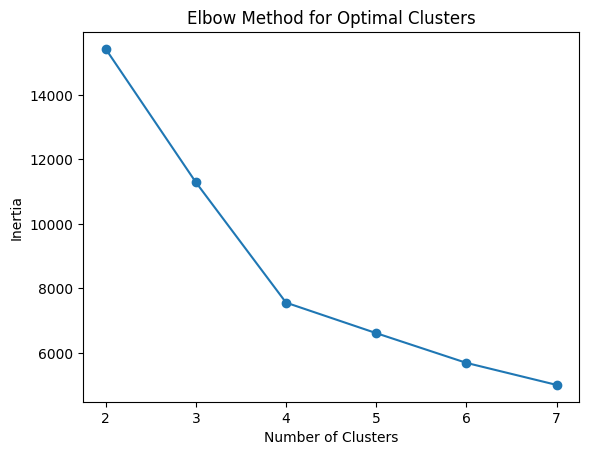

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(segment_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 8), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
customers_clean['Segment'] = kmeans.fit_predict(segment_scaled)


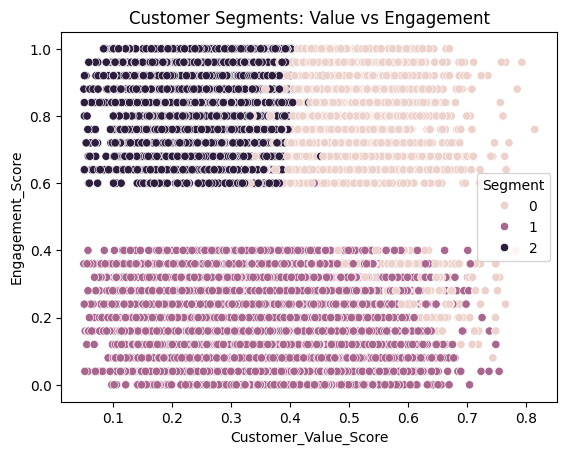

In [ ]:
import seaborn as sns

sns.scatterplot(
    x='Customer_Value_Score',
    y='Engagement_Score',
    hue='Segment',
    data=customers_clean
)
plt.title("Customer Segments: Value vs Engagement")
plt.show()


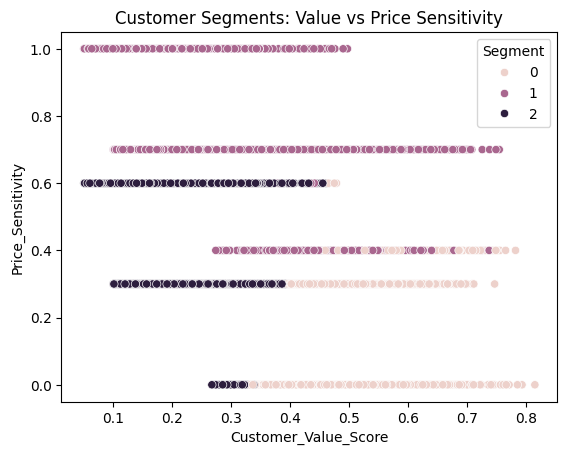

In [ ]:
sns.scatterplot(
    x='Customer_Value_Score',
    y='Price_Sensitivity',
    hue='Segment',
    data=customers_clean
)
plt.title("Customer Segments: Value vs Price Sensitivity")
plt.show()


In [ ]:
customers_clean.groupby('Segment')[
    ['Customer_Value_Score', 'Engagement_Score', 'Price_Sensitivity', 'Exited']
].mean()


,Customer_Value_Score,Engagement_Score,Price_Sensitivity,Exited
Segment,,,,
0,0.516652,0.747380,0.193305,0.190073
1,0.369225,0.198734,0.689640,0.265496
2,0.267087,0.802411,0.357374,0.114101


In [ ]:
customers_clean['Demand_Score'] = (
    customers_clean['NumOfProducts'] * 0.4 +
    customers_clean['IsActiveMember'] * 0.4 +
    (customers_clean['Balance'] / customers_clean['Balance'].max()) * 0.2
)


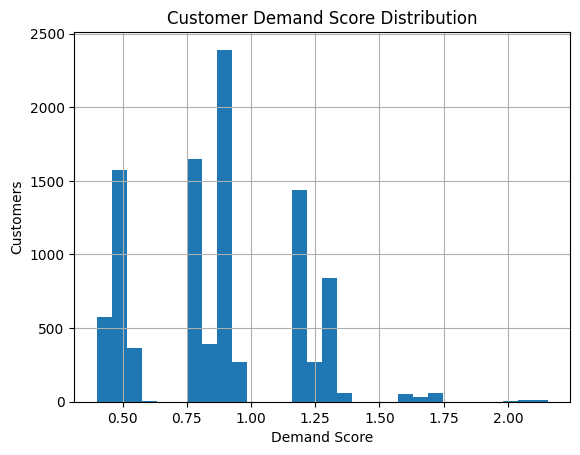

In [ ]:
customers_clean['Demand_Score'].hist(bins=30)
plt.title("Customer Demand Score Distribution")
plt.xlabel("Demand Score")
plt.ylabel("Customers")
plt.show()


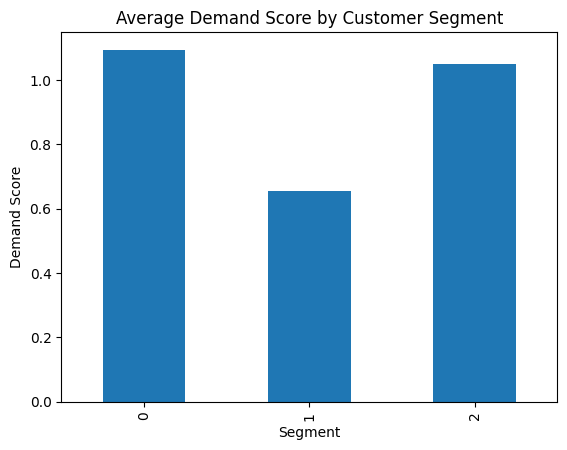

In [ ]:
customers_clean.groupby('Segment')['Demand_Score'].mean().plot(kind='bar')
plt.title("Average Demand Score by Customer Segment")
plt.ylabel("Demand Score")
plt.show()


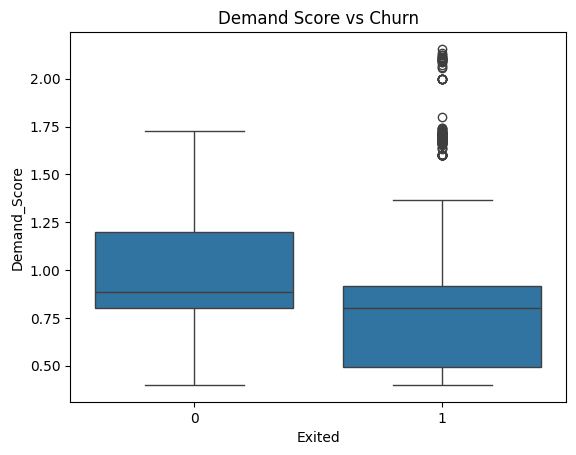

In [ ]:
import seaborn as sns

sns.boxplot(x='Exited', y='Demand_Score', data=customers_clean)
plt.title("Demand Score vs Churn")
plt.show()


In [ ]:
# Base interest rate (proxy)
customers_clean['Base_Rate'] = 0.10   # 10%


In [ ]:
customers_clean['Rate_Discount'] = customers_clean['Base_Rate'] - 0.02
customers_clean['Rate_Premium']  = customers_clean['Base_Rate'] + 0.02


In [ ]:
customers_clean['Demand_Discount'] = (
    customers_clean['Demand_Score'] *
    (1 + customers_clean['Price_Sensitivity'])
)

customers_clean['Demand_Premium'] = (
    customers_clean['Demand_Score'] *
    (1 - customers_clean['Price_Sensitivity'])
)


In [ ]:
customers_clean['Revenue_Base'] = (
    customers_clean['Base_Rate'] *
    customers_clean['Demand_Score'] *
    customers_clean['Customer_Value_Score']
)

customers_clean['Revenue_Discount'] = (
    customers_clean['Rate_Discount'] *
    customers_clean['Demand_Discount'] *
    customers_clean['Customer_Value_Score']
)

customers_clean['Revenue_Premium'] = (
    customers_clean['Rate_Premium'] *
    customers_clean['Demand_Premium'] *
    customers_clean['Customer_Value_Score']
)


In [ ]:
customers_clean.groupby('Segment')[
    ['Revenue_Base', 'Revenue_Discount', 'Revenue_Premium']
].mean()


,Revenue_Base,Revenue_Discount,Revenue_Premium
Segment,,,
0,0.056747,0.052996,0.056699
1,0.024186,0.031426,0.010908
2,0.027923,0.029809,0.022300


In [ ]:
def pricing_strategy(segment):
    if segment == 0:
        return "Premium / No Discount"
    elif segment == 1:
        return "Discounted Pricing"
    else:
        return "Mild Incentives"

customers_clean['Pricing_Strategy'] = customers_clean['Segment'].apply(pricing_strategy)


In [ ]:
decision_table = customers_clean[[
    'Segment',
    'Customer_Value_Score',
    'Engagement_Score',
    'Price_Sensitivity',
    'Demand_Score',
    'Pricing_Strategy'
]]

decision_table.head()


,Segment,Customer_Value_Score,Engagement_Score,Price_Sensitivity,Demand_Score,Pricing_Strategy
0,2,0.202029,0.68,0.6,0.800000,Mild Incentives
1,2,0.385836,0.64,0.3,0.866806,Mild Incentives
2,0,0.639082,0.32,0.4,1.327271,Premium / No Discount
3,1,0.240745,0.04,0.7,0.800000,Discounted Pricing
4,0,0.418754,0.68,0.3,0.900049,Premium / No Discount


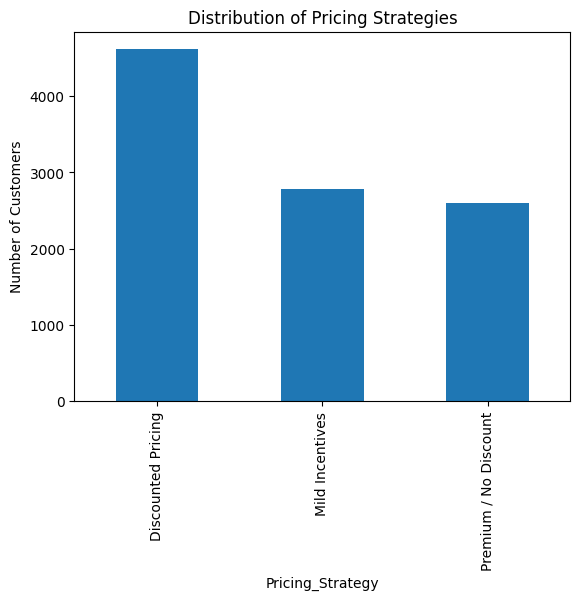

In [ ]:
decision_table['Pricing_Strategy'].value_counts().plot(kind='bar')
plt.title("Distribution of Pricing Strategies")
plt.ylabel("Number of Customers")
plt.show()


In [ ]:
!pip install datasets


In [ ]:
import pandas as pd

reviews = pd.read_csv("/content/bank_reviews3.csv")
reviews.head()


,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,"Mar 20, 2020",Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


In [ ]:
reviews.shape
reviews.columns


Index(['author', 'date', 'address', 'bank', 'rating', 'review_title_by_user',
       'review', 'bank_image', 'rating_title_by_user', 'useful_count'],
      dtype='object')

In [ ]:
reviews_clean = reviews[['bank', 'rating', 'review']]
reviews_clean.head()


,bank,rating,review
0,SBI,4.0,State Bank Of India is located nearby in our a...
1,SBI,5.0,"I have my salary account in SBI, when I applie..."
2,Axis Bank,5.0,I am using Axis bank saving account for the p...
3,HDFC Bank,5.0,I have my salary bank account in HDFC bank for...
4,review,5.0,"Close to around 10 years, I am holding this Co..."


In [ ]:
reviews_clean.isnull().sum()


,0
bank,0
rating,0
review,0


In [ ]:
reviews_clean = reviews_clean.dropna(subset=['review'])


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

reviews_clean['clean_review'] = reviews_clean['review'].apply(clean_text)


In [ ]:
from textblob import TextBlob

reviews_clean['sentiment_score'] = reviews_clean['clean_review'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)


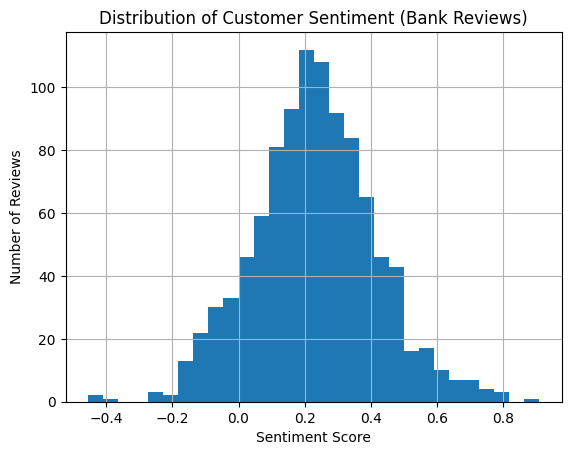

In [ ]:
import matplotlib.pyplot as plt

reviews_clean['sentiment_score'].hist(bins=30)
plt.title("Distribution of Customer Sentiment (Bank Reviews)")
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Reviews")
plt.show()


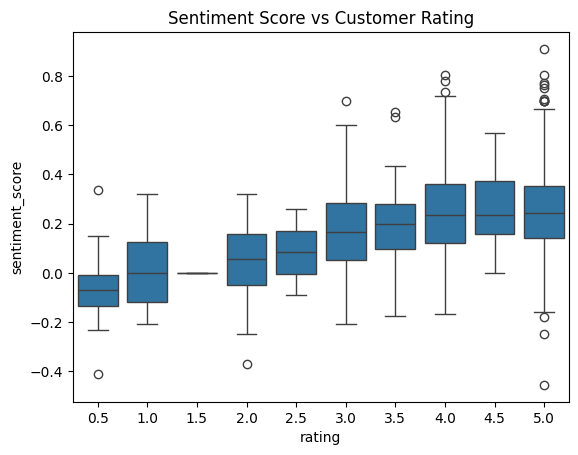

In [ ]:
import seaborn as sns

sns.boxplot(x='rating', y='sentiment_score', data=reviews_clean)
plt.title("Sentiment Score vs Customer Rating")
plt.show()


In [ ]:
pricing_keywords = [
    "interest", "rate", "fee", "charge",
    "cost", "pricing", "emi", "penalty"
]

reviews_clean['pricing_related'] = reviews_clean['clean_review'].apply(
    lambda x: any(word in x for word in pricing_keywords)
)

reviews_clean[['review', 'sentiment_score', 'pricing_related']].head()


,review,sentiment_score,pricing_related
0,State Bank Of India is located nearby in our a...,0.421111,False
1,"I have my salary account in SBI, when I applie...",0.400000,False
2,I am using Axis bank saving account for the p...,0.150000,True
3,I have my salary bank account in HDFC bank for...,0.460000,False
4,"Close to around 10 years, I am holding this Co...",0.383333,True


In [ ]:
reviews_clean['Pricing_Sentiment_Risk'] = (
    (reviews_clean['sentiment_score'] < 0) &
    (reviews_clean['pricing_related'])
).astype(int)


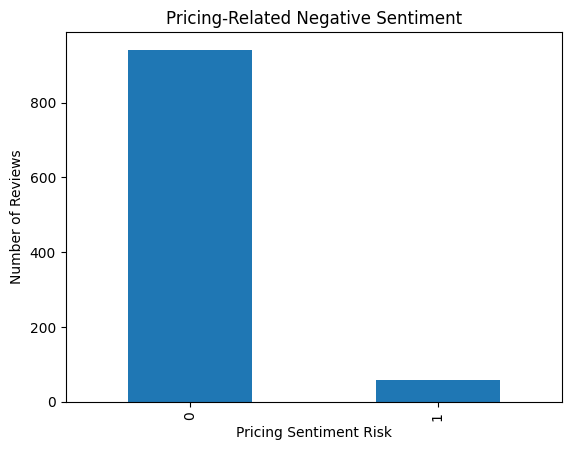

In [ ]:
reviews_clean['Pricing_Sentiment_Risk'].value_counts().plot(kind='bar')
plt.title("Pricing-Related Negative Sentiment")
plt.xlabel("Pricing Sentiment Risk")
plt.ylabel("Number of Reviews")
plt.show()


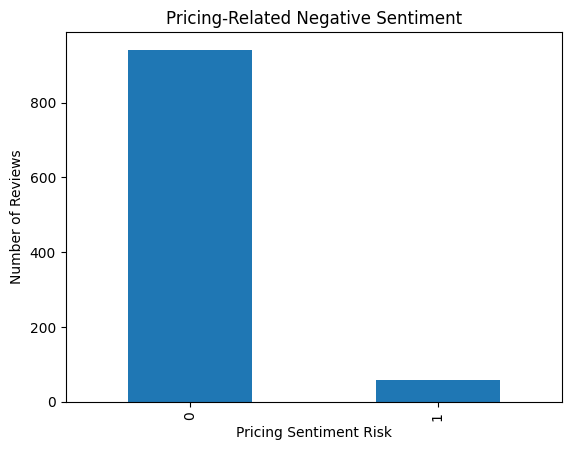

In [ ]:
reviews_clean['Pricing_Sentiment_Risk'].value_counts().plot(kind='bar')
plt.title("Pricing-Related Negative Sentiment")
plt.xlabel("Pricing Sentiment Risk")
plt.ylabel("Number of Reviews")
plt.show()


In [ ]:
bank_sentiment = (
    reviews_clean
    .groupby('bank')
    .agg(
        avg_sentiment=('sentiment_score', 'mean'),
        pricing_risk_rate=('Pricing_Sentiment_Risk', 'mean'),
        review_count=('review', 'count')
    )
    .reset_index()
)

bank_sentiment.head()


,bank,avg_sentiment,pricing_risk_rate,review_count
0,Axis Bank,0.208557,0.076336,131
1,Canara Bank,0.263249,0.057143,35
2,Citibank,0.209627,0.214286,14
3,HDFC Bank,0.243259,0.047872,188
4,IDBI,0.237689,0.000000,14


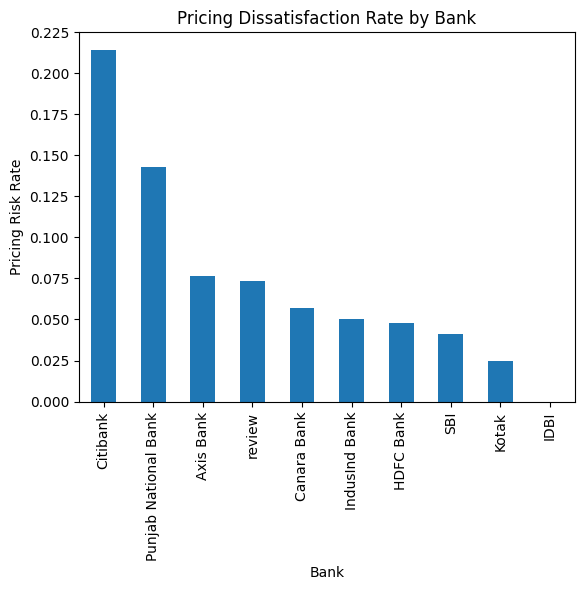

In [ ]:
bank_sentiment.sort_values('pricing_risk_rate', ascending=False) \
    .head(10) \
    .plot(
        x='bank',
        y='pricing_risk_rate',
        kind='bar',
        legend=False
    )

plt.title("Pricing Dissatisfaction Rate by Bank")
plt.ylabel("Pricing Risk Rate")
plt.xlabel("Bank")
plt.show()


In [ ]:
bank_sentiment['Pricing_Pressure_Index'] = (
    bank_sentiment['pricing_risk_rate'] *
    (1 / bank_sentiment['avg_sentiment'].abs().clip(lower=0.1))
)


In [ ]:
def bank_pricing_action(pressure):
    if pressure > 1.5:
        return "Urgent Pricing Review"
    elif pressure > 0.8:
        return "Targeted Discounts"
    else:
        return "Maintain Pricing"

bank_sentiment['Bank_Pricing_Action'] = bank_sentiment['Pricing_Pressure_Index'] \
    .apply(bank_pricing_action)

bank_sentiment.head()


,bank,avg_sentiment,pricing_risk_rate,review_count,Pricing_Pressure_Index,Bank_Pricing_Action
0,Axis Bank,0.208557,0.076336,131,0.366019,Maintain Pricing
1,Canara Bank,0.263249,0.057143,35,0.217067,Maintain Pricing
2,Citibank,0.209627,0.214286,14,1.022224,Targeted Discounts
3,HDFC Bank,0.243259,0.047872,188,0.196796,Maintain Pricing
4,IDBI,0.237689,0.000000,14,0.000000,Maintain Pricing


In [ ]:
final_pricing_decisions = bank_sentiment[[
    'bank',
    'avg_sentiment',
    'pricing_risk_rate',
    'Pricing_Pressure_Index',
    'Bank_Pricing_Action'
]]

final_pricing_decisions.head()


,bank,avg_sentiment,pricing_risk_rate,Pricing_Pressure_Index,Bank_Pricing_Action
0,Axis Bank,0.208557,0.076336,0.366019,Maintain Pricing
1,Canara Bank,0.263249,0.057143,0.217067,Maintain Pricing
2,Citibank,0.209627,0.214286,1.022224,Targeted Discounts
3,HDFC Bank,0.243259,0.047872,0.196796,Maintain Pricing
4,IDBI,0.237689,0.000000,0.000000,Maintain Pricing


In [ ]:
customers_clean.to_csv("customer_pricing_decisions.csv", index=False)


In [ ]:
final_pricing_decisions.to_csv("bank_pricing_pressure.csv", index=False)


In [ ]:
segment_revenue = customers_clean.groupby('Segment')[[
    'Revenue_Base', 'Revenue_Discount', 'Revenue_Premium'
]].mean().reset_index()

segment_revenue.to_csv("segment_pricing_revenue.csv", index=False)
